In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import detrend
%matplotlib inline

In [4]:
from load_dataset import Dataset

In [5]:
dataset = Dataset('../data/dataset/')

In [6]:
# возьмем временной ряд, характеризующий продажи алкоголя по месяцам
ts = dataset["alcohol_sales.csv"]

/Users/technogleb/ts_march_2023/load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [7]:
ts, ts_test = ts[:250], ts[250:]

<Axes: xlabel='0'>

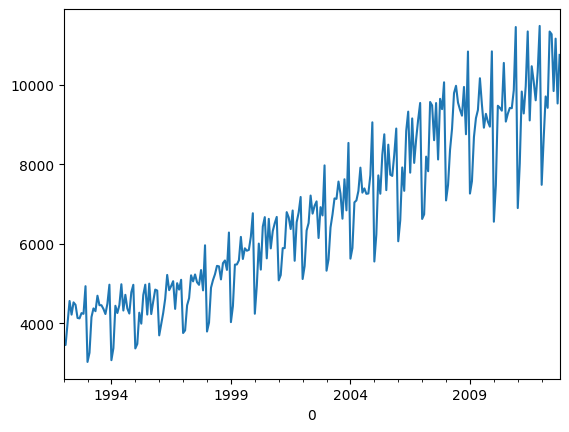

In [8]:
ts.plot()

## Box-Jenkins

In [9]:
# как можно заметить, у него есть окололинейный тренд, гетероскедастичность, сезонный период равен 12 (месяцам)

In [10]:
# сначала уберем гетероскедастичность простым логарифмированием
ts_log = np.log(ts)
plotting.plot_ts(ts_log)

Loading BokehJS ...

In [11]:
# Теперь подберем порядки дифференцирования d, D
# d малое подбирается таким образом, что d раз продифференцировав ряд, мы добьемся стационарности
# обычно таким дифференцированием убирают тренды
# D большое обычно подбирается так, что если d малое не дало стацинарности, мы можем D раз сезонно придифференцировать
# ряд, пока он не станет стационарным.

In [12]:
# для начала просто продифференцируем один раз

<Axes: xlabel='0'>

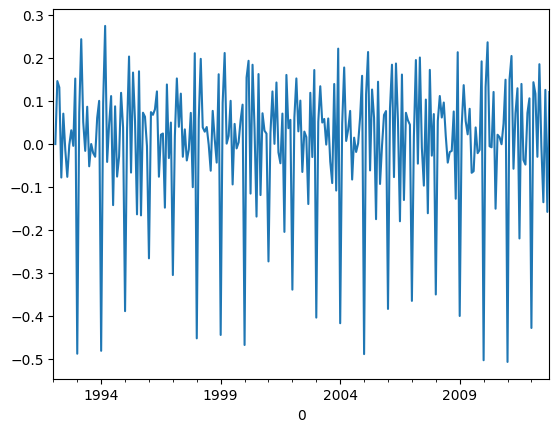

In [13]:
ts_log.diff().plot()

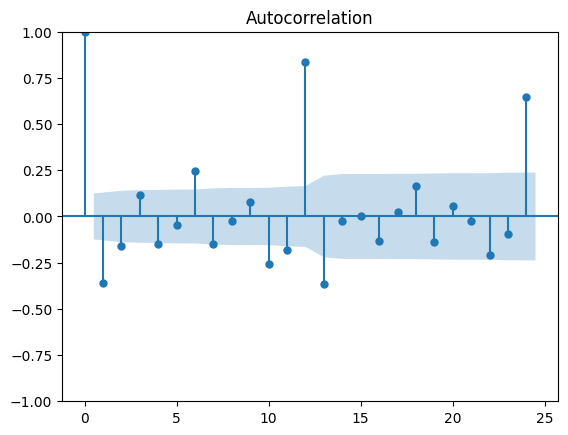

In [14]:
# в данном случае ряд сохраняет сезонность
plot_acf(ts_log.diff().dropna());

<Axes: xlabel='0'>

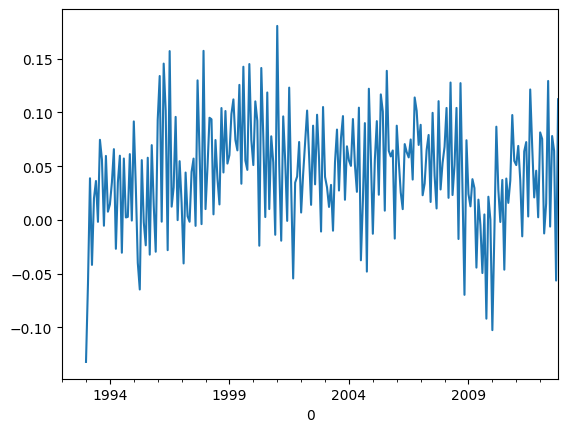

In [15]:
# попробуем применить сезонное дифференцирование 
ts_log.diff(12).plot()

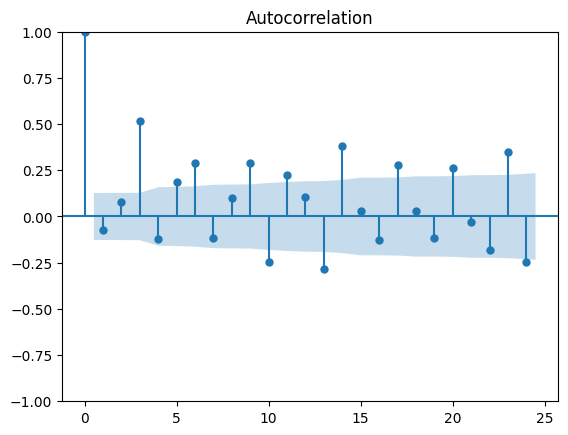

In [16]:
plot_acf(ts_log.diff(12).dropna());

In [17]:
# уже лучше
# посмотрим, что скажет критерий Дики Фуллера
# видим, что пока мы не можем отвергнуть нулевую гипотезу
adfuller(ts_log.diff(12).dropna())[1]

0.1282703781632062

<Axes: xlabel='0'>

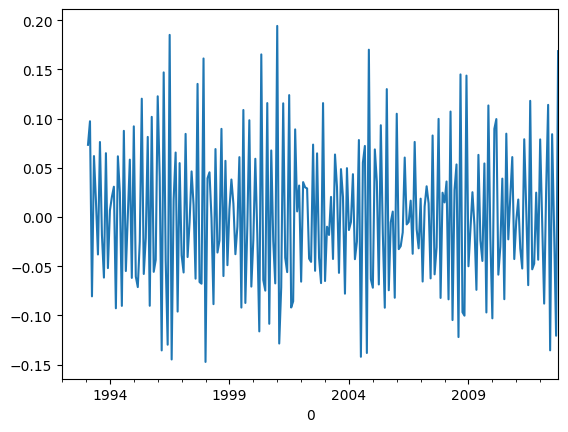

In [18]:
# давайте тогда попробуем обьединить сезонное и простое дифференцирования
ts_log.diff(12).diff().plot()

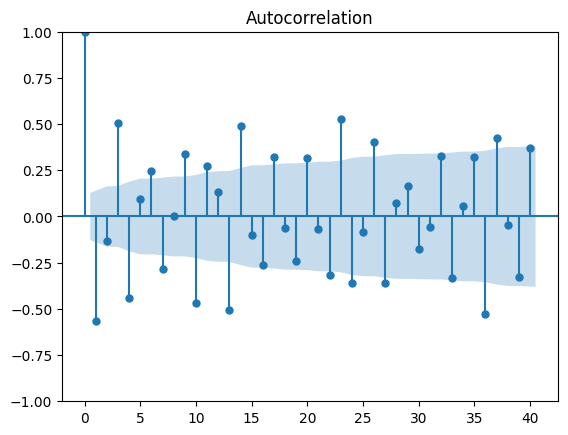

In [19]:
plot_acf(ts_log.diff(12).diff().dropna(), lags=40);

In [20]:
adfuller(ts_log.diff(12).diff().dropna())[1]

2.9448496463555435e-10

In [21]:
# отлично, вердикт о стационарности подтвержден, (d, D) = (1, 1)

In [22]:
# теперь разберемся с параметрами q, Q, p, P.

In [23]:
ts_flat = ts_log.diff(12).diff().dropna()

<Axes: xlabel='0'>

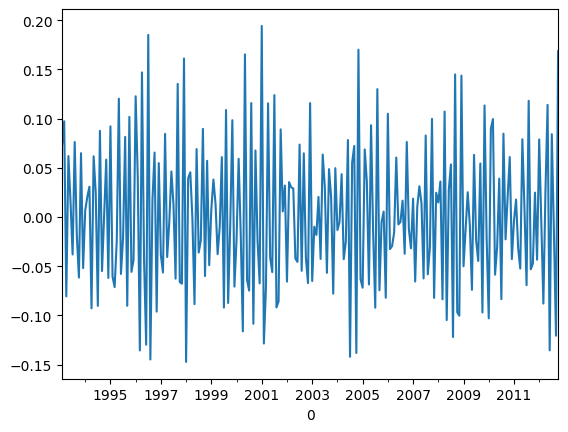

In [24]:
ts_flat.plot()

/Users/technogleb/ts_march_2023/.env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


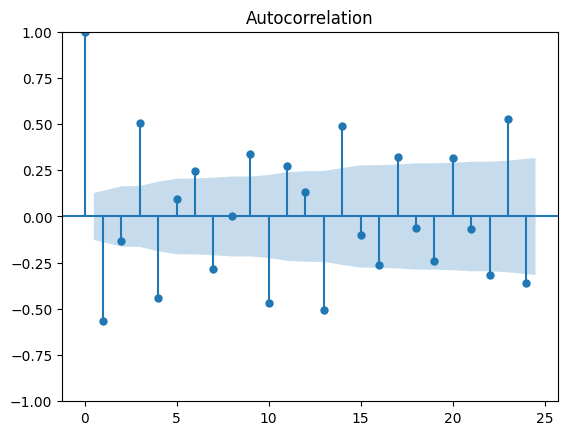

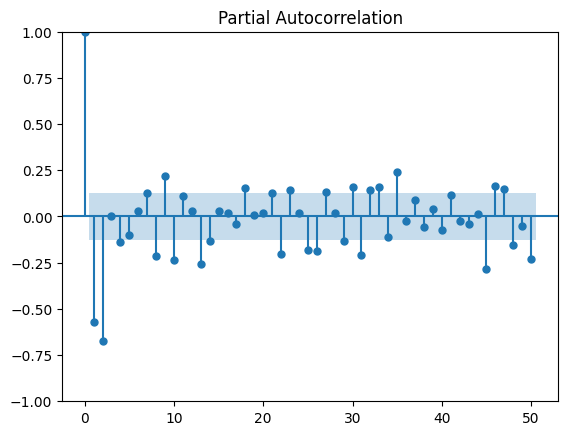

In [25]:
# отлично, для поиска параметров q, Q, p, P нарисуем график автокорреляции и частичной автокорреляции
# на графиках мы видим что резкое падение частичной автокорреляции, и плавное затухание полной автокорреляции,
# следовательно, наш ряд может быть описан моделью (p, d, 0), (P, D, 0). Итак, q = 0, Q = 0.
plot_acf(ts_flat.dropna());
plot_pacf(ts_flat, lags=50);

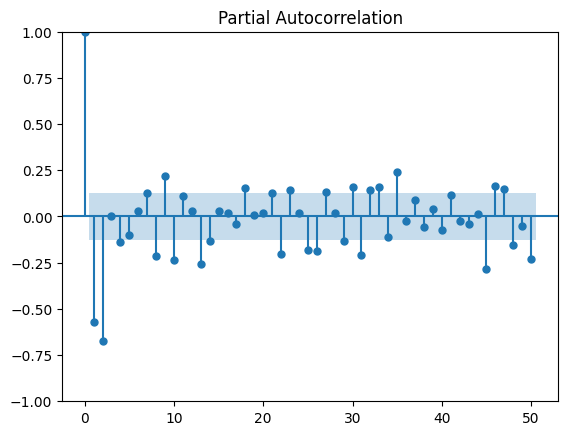

In [26]:
# найдем теперь параметры p, P
# p малое определяется как последний несезонный лаг, находящийся выше доверительного интервала
# в данном случае это p = 2, аналогично с сезонными лагами мы не видим никаких сезонных всплесков, 
# значит P = 0, итак (p, P) = (2, 0)
plot_pacf(ts_flat, lags=50);

In [27]:
# теперь попробуем построить SARIMA с этими параметрами

In [28]:
from statsmodels.tsa.statespace import sarimax

In [29]:
pdq = (2, 1, 0)
PDQ = (0, 1, 0, 12)

In [30]:
model = sarimax.SARIMAX(ts_log, order=pdq, seasonal_order=PDQ)

/Users/technogleb/ts_march_2023/.env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/technogleb/ts_march_2023/.env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [31]:
res = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61808D+00    |proj g|=  3.98049D-01

At iterate    5    f= -1.61817D+00    |proj g|=  5.06175D-02

At iterate   10    f= -1.61822D+00    |proj g|=  1.79564D-02

At iterate   15    f= -1.61831D+00    |proj g|=  5.80579D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     60      2     0     0   1.659D-03  -1.618D+00
  F =  -1.6183166965449940     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/technogleb/ts_march_2023/.env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
preds = res.forecast(69)

In [33]:
plotting.plot_ts(ts_log, preds)

Loading BokehJS ...

In [34]:
# восстановим в изначальном масштабе
plotting.plot_ts(np.exp(ts_log), ts_test, np.exp(preds))

Loading BokehJS ...

In [35]:
# Видим что получилось весьма неплохо!

In [36]:
# чтобы убедиться еще раз, давайте проанализируем остатки

In [37]:
res = (np.exp(preds) - ts_test)

<Axes: >

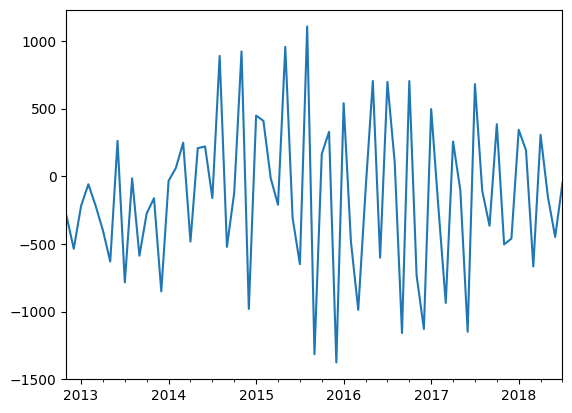

In [38]:
res.plot()

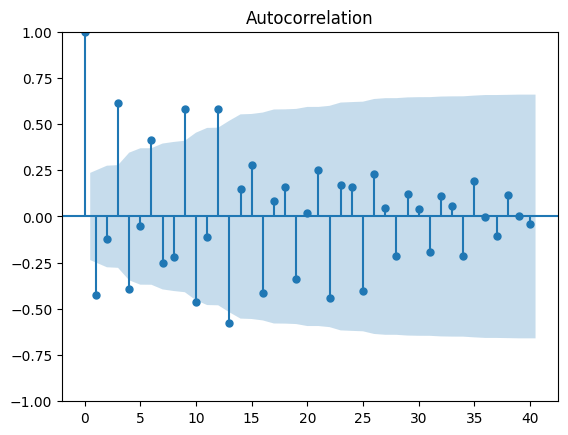

In [39]:
plot_acf(res, lags=40);

In [40]:
from sklearn.metrics import mean_squared_error as mse

mse(np.exp(preds), ts_test)

351415.0657105707

## Auto arima

In [41]:
# наиболее удобная реализация AutoArima находится в модуле pmdarima
from pmdarima import auto_arima

In [42]:
# на вход подается ряд со всеми преобразованиями кроме дифференцирования, границы поиска параметров p, q, P, Q, 
# периодом сезонности m, параметрами дифференцирования d, D
model = auto_arima(
     ts_log, start_p=0, start_q=0,
     max_p=3, max_q=3, m=12,
     start_P=0, start_Q=0, seasonal=True,
     d=1, D=1, trace=True,
     error_action='ignore',
     suppress_warnings=True,
     stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-556.970, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-647.918, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-649.023, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=-803.158, Time=0.13 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-806.341, Time=0.29 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-823.880, Time=0.59 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-679.155, Time=0.62 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-822.275, Time=0.79 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-822.636, Time=0.74 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-

In [43]:
# в результате работы возвращается обьект ARIMA
model

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [44]:
# прогноз можем получить методом predict, указав горизонт прогнозирования
preds = model.predict(len(ts_test))

In [45]:
plotting.plot_ts(np.exp(ts_log), ts_test, pd.Series(np.exp(preds), index=ts_test.index))

Loading BokehJS ...